# Some experiences regarding the affine_grid pytorch function

In [1]:
import os, sys
sys.path.append('C:\\Users\\matthias\\Documents\\myProjects\\TU_Bibliothek\\code\\baseline-extract')
from src.data.dataset_line_rider import DatasetLineRider
from src.utils.normalize_baselines import *

import torch
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
def compute_start_and_angle_old(baseline, idx):
    if torch.abs(baseline[idx, 0] - baseline[idx + 1, 0]) < 0.001:
        angle = torch.tensor(math.pi / 2.0)
    else:
        angle = torch.atan((baseline[idx, 1] - baseline[idx + 1, 1]) / (baseline[idx, 0] - baseline[idx + 1, 0]))
    # TODO: ^ make sure that the angle doesn't flip for vertical baselines

    x = baseline[idx, 0]
    y = baseline[idx, 1]

    return x, y, angle

In [3]:
parameters = {"input_folder": '..\\data\\cBAD-ICDAR2019', "max_side": 1024}

In [4]:
shuffle = {'train': False, 'eval': False}
batch_size_dict = {'train': 1, 'eval': 1}

image_datasets = {inf_type: DatasetLineRider(inf_type=inf_type,
                                            parameters=parameters)
                  for inf_type in ['train', 'eval']}

dataloaders = {inf_type: torch.utils.data.DataLoader(image_datasets[inf_type],
                                                     batch_size=batch_size_dict[inf_type],
                                                     shuffle=shuffle[inf_type],
                                                     num_workers=4)
               for inf_type in ['train', 'eval']}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


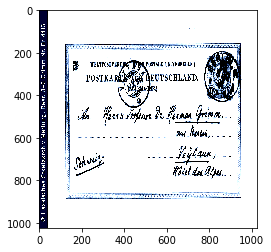

In [5]:
d0 = image_datasets['train'][80]
plt.imshow(d0['image'].permute(1,2,0).numpy())

In [6]:
bl_lengths = d0['bl_lengths']

In [7]:
import torchvision
import matplotlib.pyplot as plt

In [8]:
bl_lengths[12]

tensor(-1)

In [9]:
n = 10
step = 0
size_par = 128

In [10]:
box_width = 64
box_height = 32

bl = d0['baselines'][n][:bl_lengths[n]]
bl_n = normalize_baselines(bl, box_width)
my_bl = bl_n
baselines_n = [normalize_baselines(b[:bl_lengths[n]], box_width) for n, b in enumerate(d0['baselines'][0:21])]

In [11]:
input_t = d0['image'].unsqueeze(0)

In [12]:
x_0, y_0, angle = compute_start_and_angle(bl_n, step)


img_w = input_t.size(3)
img_h = input_t.size(2)

w_box_ratio = box_width/img_w
h_box_ratio = box_height/img_h

# grid_sample expects grid coordinates scaled to [-1,1]. This means that (-1,-1) is the top left corner and
# (1,1) is the bottom right corner.
w_box = box_width/img_w*2
h_box = box_height/img_h*2
x_scaled = x_0/img_w*2
y_scaled = y_0/img_h*2

alpha = torch.tensor(angle)
x_s = -1.0+x_scaled+np.cos(angle)*w_box/2
y_s = -1.0+y_scaled-np.sin(angle)*w_box/2
scale_x = w_box_ratio
scale_y = h_box_ratio
theta = torch.tensor([[scale_x*torch.cos(alpha), -scale_x*torch.sin(alpha), x_s],[scale_y*torch.sin(alpha), scale_y*torch.cos(alpha), y_s]]).unsqueeze(0).float()
size = (1, 3, size_par, size_par) #input_t.shape


agrid = torch.nn.functional.affine_grid(theta, size, align_corners=None)
grid_out = torch.nn.functional.grid_sample(input_t, agrid, mode='bilinear', padding_mode='zeros', align_corners=None)

c:\users\matthias\documents\myprojects\tu_bibliothek\code\baseline-extract\venv\lib\site-packages\ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\users\matthias\documents\myprojects\tu_bibliothek\code\baseline-extract\venv\lib\site-packages\torch\nn\functional.py:2751: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "
c:\users\matthias\documents\myprojects\tu_bibliothek\code\baseline-extract\venv\lib\site-packages\torch\nn\functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default gri

In [44]:
box_width = 256
box_height = 128

alpha = torch.tensor(angle)
scale_x = box_width/1024
scale_y = box_height/1024
x_s = -1.0+(x_scaled+torch.cos(angle)*scale_x/2)*torch.cos(alpha) - (y_scaled+torch.sin(angle)*scale_y/2)*torch.sin(alpha)#+torch.cos(angle)*scale_x/2
y_s = -1.0+(x_scaled+torch.cos(angle)*scale_x/2)*torch.sin(alpha) + (y_scaled+torch.sin(angle)*scale_y/2)*torch.cos(alpha)#+torch.sin(angle)*scale_y/2 #TODO: plus or minus


x_s= -1.0 + x_scaled + box_width/(1*1024)*torch.cos(alpha) - box_height/(4*1024)*torch.sin(alpha)
y_s= -1.0 + y_scaled - box_width/(1*1024)*torch.sin(alpha) - box_height/(4*1024)*torch.cos(alpha)

theta_rot = torch.tensor([[torch.cos(-alpha), -torch.sin(-alpha), x_s],[torch.sin(-alpha), torch.cos(-alpha), y_s], [0, 0, 1]])
theta_scale = torch.tensor([[scale_x, 0, 0],[0, scale_y, 0], [0, 0, 1]])
theta = torch.mm(theta_rot, theta_scale)[0:2].unsqueeze(0).float()

print('Theta:')
print(theta)

size = (1, 3, box_height, box_width) #input_t.shape
agrid = torch.nn.functional.affine_grid(theta, size, align_corners=None)
grid_out = torch.nn.functional.grid_sample(input_t, agrid, mode='bilinear', padding_mode='zeros', align_corners=None)

c:\users\matthias\documents\myprojects\tu_bibliothek\code\baseline-extract\venv\lib\site-packages\ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


Theta:
tensor([[[ 0.2286,  0.0506, -0.4612],
         [-0.1011,  0.1143,  0.3474]]])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


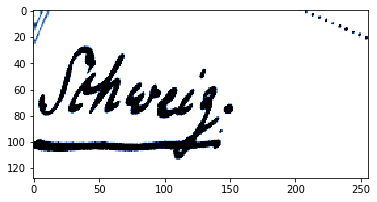

In [45]:
grid_image = grid_out[0].permute(1,2,0).numpy()
plt.imshow(grid_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


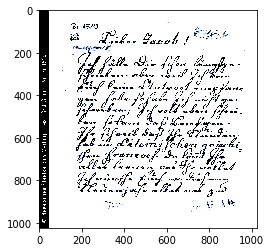

In [504]:
plt.imshow(d0['image'].permute(1,2,0).numpy())

In [70]:
import torch
import torch.nn as nn
import math

In [26]:
x = torch.rand((1,3,32,32))

In [68]:
model_brain = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3),
    nn.Flatten(),
    nn.Linear(in_features=64, out_features=8)
)

In [69]:
model_brain(x).shape

torch.Size([1, 8])

In [83]:
alpha = torch.tensor(math.pi/4)
rot = torch.tensor([[torch.cos(alpha), -torch.sin(alpha)], [torch.sin(alpha), torch.cos(alpha)]])
a = torch.tensor([[2],[1]]).float()
b = torch.tensor([[3],[2]]).float()

In [84]:
a.shape

torch.Size([2, 1])

In [85]:
torch.mm(rot,a)

tensor([[0.7071],
        [2.1213]])

In [86]:
torch.mm(rot,b)

tensor([[0.7071],
        [3.5355]])

In [88]:
torch.tensor(2.0)**3

tensor(8.)

In [98]:
def point_line_distance(x_0, y_0, xp_1, yp_1, xp_2, yp_2):
    # Taken from: https://en.wikipedia.org/wiki/Distance_from_a_point_to_a_line
    return torch.abs((yp_2-yp_1)*x_0 - (xp_2-xp_1)*y_0 + xp_2*yp_1 - yp_2*xp_1)/torch.sqrt((yp_2-yp_1)**2 + (xp_2-xp_1)**2)

In [107]:
x_0 = torch.tensor(-1.0)
y_0 = torch.tensor(0.0)
xp_1 = torch.tensor(0.0)
yp_1 = torch.tensor(0.0)
xp_2 = torch.tensor(1.0)
yp_2 = torch.tensor(1.0)

In [108]:
point_line_distance(x_0, y_0, xp_1, yp_1, xp_2, yp_2)

tensor(0.7071)